In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV #used for finding optimum number of features
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,f1_score


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  

In [2]:
data = pd.read_csv("Fraud_Detection.csv", header=0)

In [3]:
data.describe(include='all')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,...,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000,99776.000000
mean,42512.326832,-0.270695,-0.024058,0.657125,0.173522,-0.283754,0.091063,-0.121257,0.052796,-0.052008,...,-0.028584,-0.108665,-0.036607,0.008733,0.131621,0.026571,0.000296,0.002010,98.166535,0.004931
std,17488.724792,1.890413,1.678539,1.406177,1.372090,1.379589,1.304693,1.299613,1.268675,1.133966,...,0.766596,0.641080,0.638218,0.595000,0.442029,0.494770,0.400861,0.325992,265.091658,0.070048
min,0.000000,-56.407510,-72.715728,-33.680984,-5.172595,-42.147898,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.534330,-9.390980,-9.617915,0.000000,0.000000
25%,33452.000000,-1.031193,-0.597659,0.172367,-0.708895,-0.900604,-0.650199,-0.602878,-0.137719,-0.702465,...,-0.224387,-0.531342,-0.176572,-0.324092,-0.132378,-0.325209,-0.062601,-0.005376,7.530000,0.000000
50%,44252.000000,-0.262837,0.079598,0.750652,0.196889,-0.314849,-0.158707,-0.070383,0.074152,-0.120310,...,-0.057172,-0.083665,-0.049238,0.064647,0.169859,-0.070415,0.009919,0.023352,26.310000,0.000000
75%,55777.250000,1.152963,0.740262,1.374722,1.039248,0.250214,0.485321,0.414467,0.361241,0.557531,...,0.120507,0.309041,0.081874,0.406041,0.419740,0.300823,0.083486,0.076950,89.000000,0.000000
max,170348.000000,2.132386,22.057729,4.226108,16.715537,34.801666,22.529298,36.677268,20.007208,10.392889,...,27.202839,10.503090,19.002942,4.014444,5.541598,3.517346,12.152401,33.847808,19656.530000,1.000000


In [4]:
data["Time"] = data["Time"].astype('float64')
data.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [5]:
outlier_investigation = data.describe()

outlier_columns = ["Time", "Amount"]

# Boxplot approach
#Getting rid of outliers, i.e, values that are lying outside twice the interquartile range from the Q1 and Q3

for column in outlier_columns:
    
    lower_quartile = data[column].quantile(0.25)
    upper_quartile = data[column].quantile(0.75)
    iqr            = upper_quartile - lower_quartile
    iqr_extended   = iqr * 2
    min_border     = lower_quartile - iqr_extended
    max_border     = upper_quartile + iqr_extended
    
    outliers = data[(data[column] < min_border) | (data[column] > max_border) ].index
    print(f"{len(outliers)} outliers detected in column {column}")
    
    data.drop(outliers, inplace = True)

160 outliers detected in column Time
8882 outliers detected in column Amount


In [6]:
#The column values here are selected based on the important features that were identified while performing EDA of the dataset
unimp_cols = ['V1', 'V5', 'V6', 'V8', 'V13', 'V15', 'V18', 'V19', 'V20', 'V21', 'V22','V23', 'V24', 'V25', 'V26', 'V27', 'V28']
for col in unimp_cols:
    data.drop(col, axis = 1, inplace = True)
    
data

,Time,V2,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,Amount,Class
0,0.0,0.266151,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,2.69,0
1,0.0,-0.072781,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,149.62,0
3,1.0,-0.185226,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,123.50,0
4,2.0,0.960523,1.141109,-0.168252,0.476201,-0.568671,-0.371407,1.341262,0.359894,-0.137134,0.401726,-0.058133,3.67,0
5,2.0,0.877737,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99611,96717.0,4.107873,-3.803656,1.710314,-9.621560,-0.322297,-6.625692,2.175230,-4.381078,-0.673818,-4.254927,-5.160213,1.00,1
99612,97121.0,12.864989,-19.575066,11.345120,-23.783470,-8.504285,-16.601197,5.569258,-13.932249,-7.581023,-9.014813,-16.092032,8.64,1
99613,97235.0,12.352519,-20.134613,11.122771,-23.928661,-8.603038,-15.231833,4.417055,-12.893520,-3.547230,-10.402068,-18.372019,9.82,1
99614,100223.0,14.706335,-22.801238,12.114672,-28.011293,-8.960922,-18.913243,4.971249,-12.686308,-7.383370,-8.582309,-13.806568,2.28,1


In [7]:
num_attr= list(data.columns.values)
num_attr = num_attr[:-1]
num_attr

['Time',
 'V2',
 'V3',
 'V4',
 'V7',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'Amount']

In [8]:
numeric_transformer = Pipeline(steps=[
    ('impute',SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr)])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.2,
                                                    random_state=123, 
                                               stratify=data['Class'] ) #performing stratified sampling to get a good proportion mix of train and test samples

In [10]:
print(X_train.shape)
print(X_test.shape)

(72587, 13)
(18147, 13)


In [11]:
from imblearn import over_sampling #oversampling to balance the class imbalance

In [12]:
sm = over_sampling.SMOTE(random_state=1234)

In [13]:
import imblearn
import sklearn

### Decision Tree Classifier using SMOTE Technique

In [14]:
sampler = over_sampling.SMOTE() # if we have to include this in pipeline of sklearn: 
                               # Throw an error
pipe = sklearn.pipeline.Pipeline([('preprocessor', preprocessor),
                                ('pipeline',imblearn.pipeline.Pipeline(
                                [('sampler',sampler),
                                ('DT',DecisionTreeClassifier())]))])

##Perform Grid Search


In [15]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Time', 'V2', 'V3', 'V4',
                                                   'V7', 'V9', 'V10', 'V11',
                                                   'V12', 'V14', 'V16', 'V17',
                                                   'Amount'])])),
                ('pipeline',
                 Pipeline(steps=[('sampler', SMOTE()),
                                 ('DT', DecisionTreeClassifier())]))])

In [16]:
test_pred=pipe.predict(X_test)
train_pred=pipe.predict(X_train)

In [17]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72361
           1       1.00      1.00      1.00       226

    accuracy                           1.00     72587
   macro avg       1.00      1.00      1.00     72587
weighted avg       1.00      1.00      1.00     72587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18090
           1       0.61      0.82      0.70        57

    accuracy                           1.00     18147
   macro avg       0.80      0.91      0.85     18147
weighted avg       1.00      1.00      1.00     18147



### Ensemble Model (Gradient Bossting Classifier) Using SMOTE 

In [18]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('GBM',GradientBoostingClassifier(loss='exponential'))])

gbm_param_grid = {'GBM__max_depth': [8,10,12,14], 'GBM__subsample': [0.8, 0.6,], 'GBM__max_features':[0.2, 0.3], 
              'GBM__n_estimators': [10, 20, 30]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=3,n_jobs=6)

gbm_grid.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Time',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V7',
       

In [19]:
train_pred = gbm_grid.predict(X_train)
test_pred = gbm_grid.predict(X_test)

print(gbm_grid.score(X_train, y_train))
print(gbm_grid.score(X_test, y_test))

0.9989254274181327
0.9979610954978785


In [20]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72361
           1       1.00      0.65      0.79       226

    accuracy                           1.00     72587
   macro avg       1.00      0.83      0.90     72587
weighted avg       1.00      1.00      1.00     72587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18090
           1       1.00      0.35      0.52        57

    accuracy                           1.00     18147
   macro avg       1.00      0.68      0.76     18147
weighted avg       1.00      1.00      1.00     18147



### Logistic Regression using Balanced Class Weights

In [21]:
clf_lr_imp2 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(
                                                        class_weight='balanced',
                                                        max_iter=500
                                                   ))])

In [22]:
clf_lr_imp2.fit(X_train,y_train)
train_pred= clf_lr_imp2.predict(X_train)
test_pred= clf_lr_imp2.predict(X_test)

In [23]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     72361
           1       0.15      0.95      0.26       226

    accuracy                           0.98     72587
   macro avg       0.58      0.97      0.63     72587
weighted avg       1.00      0.98      0.99     72587

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18090
           1       0.15      0.88      0.26        57

    accuracy                           0.98     18147
   macro avg       0.58      0.93      0.62     18147
weighted avg       1.00      0.98      0.99     18147



### Decision Tree Classifier Using Balanced Class Weights

In [27]:
clf_DT = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',DecisionTreeClassifier(class_weight='balanced') )])

dt_param_grid = {'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [2,4,5,10], 
                 "classifier__min_samples_split": [2, 10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_DT, param_grid=dt_param_grid, cv=5,verbose=3,scoring='f1')

dt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.313 total time=   0.3s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.328 total time=   0.2s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.375 total time=   0.4s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.279 total time=   0.3s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_split=2;, score=0.279 total time=   0.7s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=2, classifier__min_samples_leaf=1, classifier__min_samples_s

[CV 1/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.222 total time=   0.4s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.124 total time=   0.4s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.154 total time=   0.5s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.140 total time=   0.5s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=10;, score=0.134 total time=   0.4s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=4, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.222 total time=   0.4s
[CV 2/5] END cla

[CV 1/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.336 total time=   1.0s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.223 total time=   0.8s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.346 total time=   0.7s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.221 total time=   1.0s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=1, classifier__min_samples_split=20;, score=0.185 total time=   0.9s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=5, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.336 total time=   0.6s
[CV 2/5] END clas

[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.697 total time=   0.9s
[CV 2/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.646 total time=   1.1s
[CV 3/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.730 total time=   0.8s
[CV 4/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.588 total time=   0.6s
[CV 5/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=2;, score=0.579 total time=   0.8s
[CV 1/5] END classifier__criterion=gini, classifier__max_depth=10, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.697 total time=   0.7s
[CV 2/5] END cl

[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.284 total time=   0.4s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.298 total time=   0.4s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.297 total time=   0.4s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.281 total time=   0.4s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.223 total time=   0.4s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.284 total time=   0.4

[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.234 total time=   0.8s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.137 total time=   0.8s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.156 total time=   0.8s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.736 total time=   0.8s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=5, classifier__min_samples_split=20;, score=0.238 total time=   1.0s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.231 total time=   0.8

[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.439 total time=   0.7s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.149 total time=   0.8s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.260 total time=   0.7s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.210 total time=   0.6s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.309 total time=   0.7s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=5, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.437 total time=   0.

[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=2;, score=0.500 total time=   0.6s
[CV 1/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.667 total time=   0.8s
[CV 2/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.500 total time=   0.8s
[CV 3/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.737 total time=   0.7s
[CV 4/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.586 total time=   0.7s
[CV 5/5] END classifier__criterion=entropy, classifier__max_depth=10, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.500 total 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Time',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V7',
       

In [28]:
dt_grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 20}

In [29]:
train_pred=dt_grid.predict(X_train)
test_pred=dt_grid.predict(X_test)

In [30]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72361
           1       0.53      1.00      0.69       226

    accuracy                           1.00     72587
   macro avg       0.77      1.00      0.85     72587
weighted avg       1.00      1.00      1.00     72587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18090
           1       0.43      0.77      0.55        57

    accuracy                           1.00     18147
   macro avg       0.71      0.88      0.77     18147
weighted avg       1.00      1.00      1.00     18147



### Random Forest Classifier 

In [43]:
clf_RF = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',RandomForestClassifier(class_weight = 'balanced') )])

rf_param_grid = { 'classifier__max_depth': [2,4,5,10], 
                 "classifier__min_samples_split": [5, 10, 20],"classifier__min_samples_leaf": [ 5, 10,15]}

rf_grid = GridSearchCV(clf_RF, param_grid=rf_param_grid, cv=5,verbose=3,scoring='f1')

rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=5;, score=0.477 total time=   5.9s
[CV 2/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=5;, score=0.710 total time=   7.3s
[CV 3/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=5;, score=0.590 total time=   7.5s
[CV 4/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=5;, score=0.372 total time=   5.9s
[CV 5/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=5;, score=0.417 total time=   8.6s
[CV 1/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.769 total time=   8.4s
[CV 2/5] END classifier__max_depth=2, classifier__min_samples_leaf=5, classifier__min_samples_split=10;, score=0.693 total time

[CV 1/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=5;, score=0.833 total time=  12.2s
[CV 2/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=5;, score=0.800 total time=  11.4s
[CV 3/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=5;, score=0.781 total time=  12.5s
[CV 4/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=5;, score=0.851 total time=  14.6s
[CV 5/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=5;, score=0.784 total time=  11.8s
[CV 1/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.851 total time=  13.4s
[CV 2/5] END classifier__max_depth=4, classifier__min_samples_leaf=10, classifier__min_samples_split=10;, score=0.846 total time=  12.9s
[CV 3/5] END classifier__max_depth=4, classifi

[CV 2/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=5;, score=0.848 total time=  14.2s
[CV 3/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=5;, score=0.812 total time=  13.4s
[CV 4/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=5;, score=0.842 total time=  13.3s
[CV 5/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=5;, score=0.851 total time=  11.5s
[CV 1/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=10;, score=0.851 total time=  13.7s
[CV 2/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=10;, score=0.860 total time=  18.3s
[CV 3/5] END classifier__max_depth=5, classifier__min_samples_leaf=15, classifier__min_samples_split=10;, score=0.812 total time=  21.4s
[CV 4/5] END classifier__max_depth=5, classif

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Time',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V7',
       

In [44]:
rf_grid.best_params_

{'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 5}

In [45]:
train_pred=rf_grid.predict(X_train)
test_pred=rf_grid.predict(X_test)

In [46]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72361
           1       0.90      1.00      0.95       226

    accuracy                           1.00     72587
   macro avg       0.95      1.00      0.97     72587
weighted avg       1.00      1.00      1.00     72587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18090
           1       0.85      0.79      0.82        57

    accuracy                           1.00     18147
   macro avg       0.92      0.89      0.91     18147
weighted avg       1.00      1.00      1.00     18147



### Random Forest using SMOTE-ing techniques and balanced class weights

In [47]:
sampler = over_sampling.SMOTE() # if we have to include this in pipeline of sklearn: 
                               # Throw an error
pipe = sklearn.pipeline.Pipeline([('preprocessor', preprocessor),
                                ('pipeline',imblearn.pipeline.Pipeline(
                                [('sampler',sampler),
                                ('classifier',RandomForestClassifier(class_weight = 'balanced'))]))])


In [48]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Time', 'V2', 'V3', 'V4',
                                                   'V7', 'V9', 'V10', 'V11',
                                                   'V12', 'V14', 'V16', 'V17',
                                                   'Amount'])])),
                ('pipeline',
                 Pipeline(steps=[('sampler', SMOTE()),
                                 ('classifier',
                                  RandomForestClassifier(class_weight='balanced'))]))])

In [49]:
test_pred=pipe.predict(X_test)
train_pred=pipe.predict(X_train)

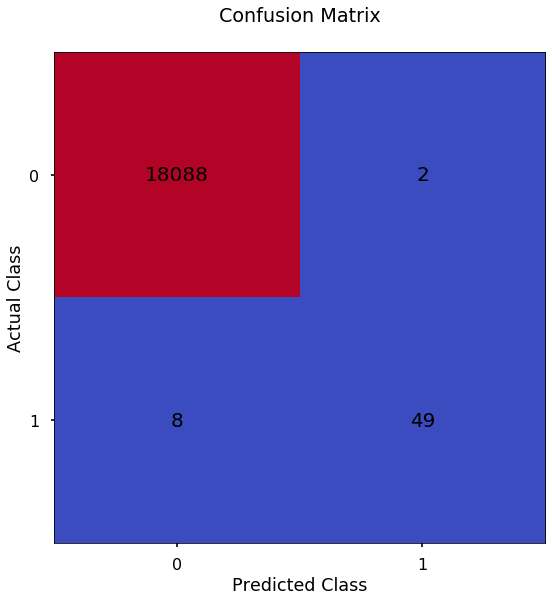

In [51]:
#Confusion Matrix for the trained model using SMOTE-ing and balanced class weights for model trained on important features.
conf_matrix = confusion_matrix(y_test, test_pred)

plt.style.use("seaborn-poster")
plt.matshow(conf_matrix, cmap = "coolwarm")
plt.gca().xaxis.tick_bottom()
plt.title("Confusion Matrix")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
for (i,j), corr_value in np.ndenumerate(conf_matrix):
    plt.text(j,i, corr_value, ha = "center", va = "center", fontsize = 20)
plt.show()

In [50]:
print(classification_report(y_train,train_pred))
print("=====================================")
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     72361
           1       1.00      1.00      1.00       226

    accuracy                           1.00     72587
   macro avg       1.00      1.00      1.00     72587
weighted avg       1.00      1.00      1.00     72587

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18090
           1       0.96      0.86      0.91        57

    accuracy                           1.00     18147
   macro avg       0.98      0.93      0.95     18147
weighted avg       1.00      1.00      1.00     18147

